# Floating Array Design Project, Deep Case, Humboldt


In [1]:
from copy import deepcopy
from time import perf_counter
from pathlib import Path

import numpy as np
import pandas as pd

from waves import Project
from waves.utilities import load_yaml

# Update core Pandas display settings
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
metrics_configuration = {
    "# Turbines": {"metric": "n_turbines"},
    "Turbine Rating (MW)": {"metric": "turbine_rating"},
    "Project Capacity (MW)": {
        "metric": "capacity",
        "kwargs": {"units": "mw"}
    },
    "# OSS": {"metric": "n_substations"},
    "Total Export Cable Length (km)": {"metric": "export_system_total_cable_length"},
    "Total Array Cable Length (km)": {"metric": "array_system_total_cable_length"},
    "CapEx ($)": {"metric": "capex"},
    "CapEx per kW ($/kW)": {
        "metric": "capex",
        "kwargs": {"per_capacity": "kw"}
    },
    "OpEx ($)": {"metric": "opex"},
    "OpEx per kW ($/kW)": {"metric": "opex", "kwargs": {"per_capacity": "kw"}},
    "AEP (MWh)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "aep": True}
    },
    "AEP per kW (MWh/kW)": {
        "metric": "energy_production",
        "kwargs": {"units": "mw", "per_capacity": "kw", "aep": True}
    },
    "Net Capacity Factor With All Losses (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "net"}
    },
    "Gross Capacity Factor (%)": {
        "metric": "capacity_factor",
        "kwargs": {"which": "gross"}
    },
    "Energy Availability (%)": {
        "metric": "availability",
        "kwargs": {"which": "energy"}
    },
    "LCOE ($/MWh)": {"metric": "lcoe"},
}


# Define the final order of the metrics in the resulting dataframes
metrics_order = [
    "# Turbines",
    "Turbine Rating (MW)",
    "Project Capacity (MW)",
    "# OSS",
    "Total Export Cable Length (km)",
    "Total Array Cable Length (km)",
    "FCR (%)",
    "Offtake Price ($/MWh)",
    "CapEx ($)",
    "CapEx per kW ($/kW)",
    "OpEx ($)",
    "OpEx per kW ($/kW)",
    "Annual OpEx per kW ($/kW)",
    "Energy Availability (%)",
    "Gross Capacity Factor (%)",
    "Net Capacity Factor With All Losses (%)",
    "AEP (MWh)",
    "AEP per kW (MWh/kW)",
    "LCOE ($/MWh)",
    "Potential AEP from WOMBAT (kWh)",
    "Production AEP from WOMBAT (kWh)",
]

capex_order = [
    "Array System",
    "Export System",
    "Offshore Substation",
    "Substructure",
    "Scour Protection",
    "Mooring System",
    "Turbine",
    "Array System Installation",
    "Export System Installation",
    "Offshore Substation Installation",
    "Substructure Installation",
    "Scour Protection Installation",
    "Mooring System Installation",
    "Turbine Installation",
    "Soft",
    "Project",
]

In [3]:
def run_waves(project_floating):
    start2 = perf_counter()
    project_floating.run(full_wind_rose=False)
    project_floating.wombat.env.cleanup_log_files()  # Delete logging data from the WOMBAT simulations
    end2 = perf_counter()
    
    print("-" * 29)  # separate our timing from the ORBIT and FLORIS run-time warnings
    print(f"Floating run time: {end2 - start2:,.2f} seconds")

    return project_floating

def average_and_save(dfs, filename, index_cols=None):
    df_concat = pd.concat(dfs)
    if index_cols:
        df_avg = df_concat.groupby(index_cols).mean()
    else:
        df_avg = df_concat.groupby(level=0).mean()
    df_avg.to_csv(filename)
    print(f"Saved: {filename}")

In [4]:
NUM_RUNS = 50
rng = np.random.default_rng(seed=834)

# Containers for each metric
capex_dfs = []
opex_dfs = []
charter_days_dfs = []
mobilization_dfs = []
delay_dfs = []
failure_cost_dfs = []
equipment_cost_dfs = []
report_dfs = []
losses_dfs = []

library_path = Path("../library/IEA_49/")
config_floating = load_yaml(library_path / "project/config", "base_floating_deep.yaml")
config_floating["floris_config"] = load_yaml(library_path / "project/config", config_floating["floris_config"])
config_floating["floris_config"]["farm"]["turbine_library_path"] = library_path / "turbines"
config_floating.update({"library_path": library_path})

config_wombat = load_yaml(library_path / "project/config", config_floating["wombat_config"])

for i in range(NUM_RUNS):
    print(f"\nRun {i + 1} of {NUM_RUNS}")

    # Load the project
    config = deepcopy(config_floating)
    config_wombat["random_generator"] = rng
    config_floating["wombat_config"] = config_wombat
    
    start = perf_counter()
    project_floating = Project.from_dict(config_floating)
    end = perf_counter()
    print(f"Floating loading time: {end - start:,.2f} seconds")

    # Run simulation
    project_floating = run_waves(project_floating)

    # Load key objects
    ev = project_floating.wombat.metrics.events
    years = project_floating.wombat.env.simulation_years
    metrics = project_floating.wombat.metrics
    materials = metrics.component_costs("project", by_category=True, by_task=True, by_action=False)
    avg_materials = materials[["materials_cost"]] / years

    # 0. CapEx Breakdown
    df_capex_floating = pd.DataFrame(
        project_floating.orbit.capex_detailed_soft_capex_breakdown.items(),
        columns=["Component", "CapEx ($) - Floating"]
    )
    df_capex_floating["CapEx ($/kW) - Floating"] = (
        df_capex_floating["CapEx ($) - Floating"] / project_floating.capacity("kw")
    )

    # Extract the onshore substation cost
    onshore_substation_cost = (
        project_floating.orbit.phases["ElectricalDesign"]
        .detailed_output["export_system"]["onshore_substation_costs"]
    )
    onshore_substation_cost_per_kw = onshore_substation_cost / project_floating.capacity("kw")

    # Append onshore substation as a row
    df_capex_floating.loc[len(df_capex_floating)] = [
        "Onshore Substation",
        onshore_substation_cost,
        onshore_substation_cost_per_kw
    ]

    # Set index for consistent merging
    df_capex_floating.set_index("Component", inplace=True)
    capex_dfs.append(df_capex_floating)
    
    # 1. Annual OpEx
    opex_df = metrics.opex(frequency='annual', by_category=True)
    opex_dfs.append(opex_df)

    # 2. Average Charter Days
    average_charter_days = []
    for name, vessel in project_floating.wombat.service_equipment.items():
        if vessel.settings.onsite or "TOW" in [el.value for el in vessel.settings.capability]:
            continue
        mobilizations = ev.loc[
            (ev.action.eq("mobilization") & ev.reason.str.contains("arrived on site"))
            & ev.agent.eq(name),
            ["agent", "env_time"]
        ]
        leaving = ev.loc[
            ev.action.eq("leaving site")
            & ev.agent.eq(name),
            ["agent", "env_time"]
        ]
        if mobilizations.shape[0] - leaving.shape[0] == 1:
            mobilizations = mobilizations.iloc[:-1]
        charter_days = (leaving.env_time.values - mobilizations.env_time.values) / 24
        average_charter_days.append([name, charter_days.mean()])
    charter_days_df = pd.DataFrame(average_charter_days, columns=["vessel", "average charter days"]).set_index("vessel")
    charter_days_dfs.append(charter_days_df)

    # 3. Mobilization Summary
    mobilization_summary = (
        ev.loc[ev.action.eq("mobilization") & ev.duration.gt(0), ["agent", "duration"]]
        .groupby("agent")
        .count()
        .rename(columns={"duration": "mobilizations"})
        .join(
            ev.loc[ev.action.eq("mobilization"), ["agent", "duration", "equipment_cost"]]
            .groupby("agent")
            .sum()
        )
    )
    mobilization_summary.duration /= 24
    mobilization_dfs.append(mobilization_summary)

    # 4. Delay Summary
    delay_summary = (
        ev.loc[
            ev.agent.isin(project_floating.wombat.service_equipment)
            & ev.duration.gt(0)
            & ev.action.eq("delay"),
            ["agent", "additional", "duration"]
        ]
        .replace({
            "no work requests submitted by start of shift": "no requests",
            "no work requests, waiting until the next shift": "no requests",
            "weather unsuitable to transfer crew": "weather delay",
            "work shift has ended; waiting for next shift to start": "end of shift",
            "insufficient time to complete travel before end of the shift": "end of shift",
            "will return next year": "end of charter",
        })
        .groupby(["agent", "additional"])
        .sum()
        .reset_index(drop=False)
        .set_index(["agent", "additional"])
        / 24
    )
    delay_dfs.append(delay_summary)

    # 5. Failure Costs
    timing = metrics.process_times()[["N"]].rename(columns={"N": "annual_occurrences"}) / years
    average_failures_costs = (
        avg_materials
        .rename(columns={"materials_cost": "annual_materials_cost"})
        .join(timing, how="outer")
        .fillna(0.0)
    )
    failure_cost_dfs.append(average_failures_costs)

    # 6. Equipment Cost Summary
    equipment_cost_df = metrics.equipment_costs(frequency="annual", by_equipment=True)
    equipment_cost_dfs.append(equipment_cost_df)

    # 7. Report DF
    project_name_floating = "FAD Deep Case - Floating"
    report_df_floating = project_floating.generate_report(metrics_configuration, project_name_floating).T
    n_years_floating = project_floating.operations_years
    additional_reporting = pd.DataFrame(
        [
            ["FCR (%)", project_floating.fixed_charge_rate],
            ["Offtake Price ($/MWh)", project_floating.offtake_price],
            [
                "Annual OpEx per kW ($/kW)",
                report_df_floating.loc["OpEx per kW ($/kW)", project_name_floating] / n_years_floating
            ],
            ["Potential AEP from WOMBAT (kWh)", project_floating.wombat.metrics.potential.windfarm.values.sum()/n_years_floating],
            ["Production AEP from WOMBAT (kWh)", project_floating.wombat.metrics.production.windfarm.values.sum()/n_years_floating],
        ],
        columns=["Project"] + report_df_floating.columns.tolist(),
    ).set_index("Project")

    report_df_floating = pd.concat((report_df_floating, additional_reporting), axis=0)
    report_df_floating.index.name = "Metrics"
    report_df_floating.loc[report_df_floating.index.str.contains("%")] *= 100
    report_dfs.append(report_df_floating)

    #8. Losses report
    report_df_losses = project_floating.loss_ratio(breakdown=True)
    losses_dfs.append(report_df_losses) 

# === Compute and save averages ===
average_and_save(capex_dfs, "fad-results/deep_average_capex.csv", index_cols="Component")
average_and_save(opex_dfs, "fad-results/deep_average_opex.csv")
average_and_save(charter_days_dfs, "fad-results/deep_average_charter_days.csv", index_cols="vessel")
average_and_save(mobilization_dfs, "fad-results/deep_average_mobilization_summary.csv", index_cols="agent")
average_and_save(delay_dfs, "fad-results/deep_average_delay_summary.csv", index_cols=["agent", "additional"])
average_and_save(failure_cost_dfs, "fad-results/deep_average_failures_costs.csv", index_cols=["subassembly", "task"])
average_and_save(equipment_cost_dfs, "fad-results/deep_average_equipment_costs.csv")
average_and_save(report_dfs, "fad-results/deep_average_report_df.csv", index_cols="Metrics")
average_and_save(losses_dfs, "fad-results/deep_average_losses_report_df.csv")


Run 1 of 50
ORBIT library intialized at '/Users/rhammond/GitHub_Public/WAVES/library/IEA_49'


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.21 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 82.37 seconds

Run 2 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 82.08 seconds

Run 3 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 92.66 seconds

Run 4 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.06 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 87.64 seconds

Run 5 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.07 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 82.03 seconds

Run 6 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 79.75 seconds

Run 7 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.45 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 83.11 seconds

Run 8 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.06 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 89.08 seconds

Run 9 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 73.49 seconds

Run 10 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 90.74 seconds

Run 11 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 84.38 seconds

Run 12 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 91.58 seconds

Run 13 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 89.71 seconds

Run 14 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 86.40 seconds

Run 15 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.07 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 81.49 seconds

Run 16 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 82.99 seconds

Run 17 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 88.93 seconds

Run 18 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 80.51 seconds

Run 19 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 84.41 seconds

Run 20 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 79.87 seconds

Run 21 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 86.45 seconds

Run 22 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 92.16 seconds

Run 23 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 87.29 seconds

Run 24 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.11 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 87.00 seconds

Run 25 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.02 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 81.10 seconds

Run 26 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 80.05 seconds

Run 27 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 88.22 seconds

Run 28 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 90.59 seconds

Run 29 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.09 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 84.74 seconds

Run 30 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.06 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 85.38 seconds

Run 31 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.11 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 83.68 seconds

Run 32 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 86.32 seconds

Run 33 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 88.09 seconds

Run 34 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 92.25 seconds

Run 35 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 83.93 seconds

Run 36 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.06 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 88.15 seconds

Run 37 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.07 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 82.85 seconds

Run 38 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 88.75 seconds

Run 39 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.06 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 86.76 seconds

Run 40 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 87.10 seconds

Run 41 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.08 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 87.49 seconds

Run 42 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.04 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 85.86 seconds

Run 43 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.02 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 88.48 seconds

Run 44 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.14 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 84.69 seconds

Run 45 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.07 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 94.12 seconds

Run 46 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.05 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 78.94 seconds

Run 47 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 81.95 seconds

Run 48 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 75.90 seconds

Run 49 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 85.08 seconds

Run 50 of 50


'H' is deprecated and will be removed in a future version, please use 'h' instead.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.UserWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/array_system_design.py:1085
Missing data in columns ['bury_speed']; all values will be calculated.DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/manager.py:730
landfall dictionary will be deprecated and moved into [export_system_design][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/design/_cables.py:417
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

Floating loading time: 1.03 seconds


landfall dictionary will be deprecated and moved into [export_system][landfall].DeprecationWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/ORBIT/phases/install/quayside_assembly_tow/moored.py:94
support_vessel will be deprecated and replaced with towing_vessels and ahts_vessel in the towing groups.
['towing_vessl_groups]['station_keeping_vessels'] will be deprecated and replaced with ['towing_vessl_groups]['ahts_vessels'].

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copyRuntimeWarning: /Users/rhammond/miniconda3/envs/waves/lib/python3.11/site-packages/floris/core/wake_deflection/gauss.py:328
invalid value encountered in divide

-----------------------------
Floating run time: 87.17 seconds


In [7]:
pd.concat(failure_cost_dfs).reset_index().groupby(["subassembly", "task"]).sum() / years / NUM_RUNS

annual_materials_cost  \
subassembly            task                                                               
anchor                 anchor replacement                                      1,996.80   
                       major anchor repair                                       333.75   
array cable            array cable major repair                                1,878.00   
                       array cable replacement                                 8,921.00   
ballast pump           minor ballast pump repair                                   2.65   
drive_train            main shaft major repair                                     0.00   
                       main shaft minor repair                                    69.45   
                       main shaft replacement                                      0.00   
electrical system      power electrical system major repair                        0.00   
                       power electrical system major replacement                   0.00   
                       power electrical system minor repair                      104.15   
export cable           export cable major repair                                  30.00   
                       export cable subsea inspection                             11.25   
generator              annual turbine inspection                                 276.60   
                       direct drive generator major repair                         0.00   
                       direct drive generator major replacement                    0.00   
                       direct drive generator minor repair                       159.10   
hydraulic pitch system major pitch system repair                                 105.92   
                       major pitch system replacement                              0.00   
                       minor pitch system repair                                 122.08   
mooring lines          buoyancy module replacement                             1,030.00   
                       marine growth removal                                      52.42   
                       mooring line major repair                                  79.00   
                       mooring line replacement                                  533.25   
power converter        power converter major repair                                0.00   
                       power converter minor repair                              161.65   
                       power converter replacement                                 0.00   
rotor_blades           blades major repair                                         0.00   
                       blades major replacement                                    0.00   
                       blades minor repair                                       834.00   
supporting_structure   structural annual inspection                              109.74   
                       structural subsea inspection                               40.50   
transformer            oss annual inspection                                      23.75   
                       oss major repair                                           50.00   
                       oss minor repair                                           20.00   
yaw_system             yaw system major repair                                     0.00   
                       yaw system major replacement                                0.00   
                       yaw system minor repair                                    24.35   

                                                                  annual_occurrences  
subassembly            task                                                           
anchor                 anchor replacement                                       0.03  
                       major anchor repair                                      0.04  
array cable            array cable major repair                              

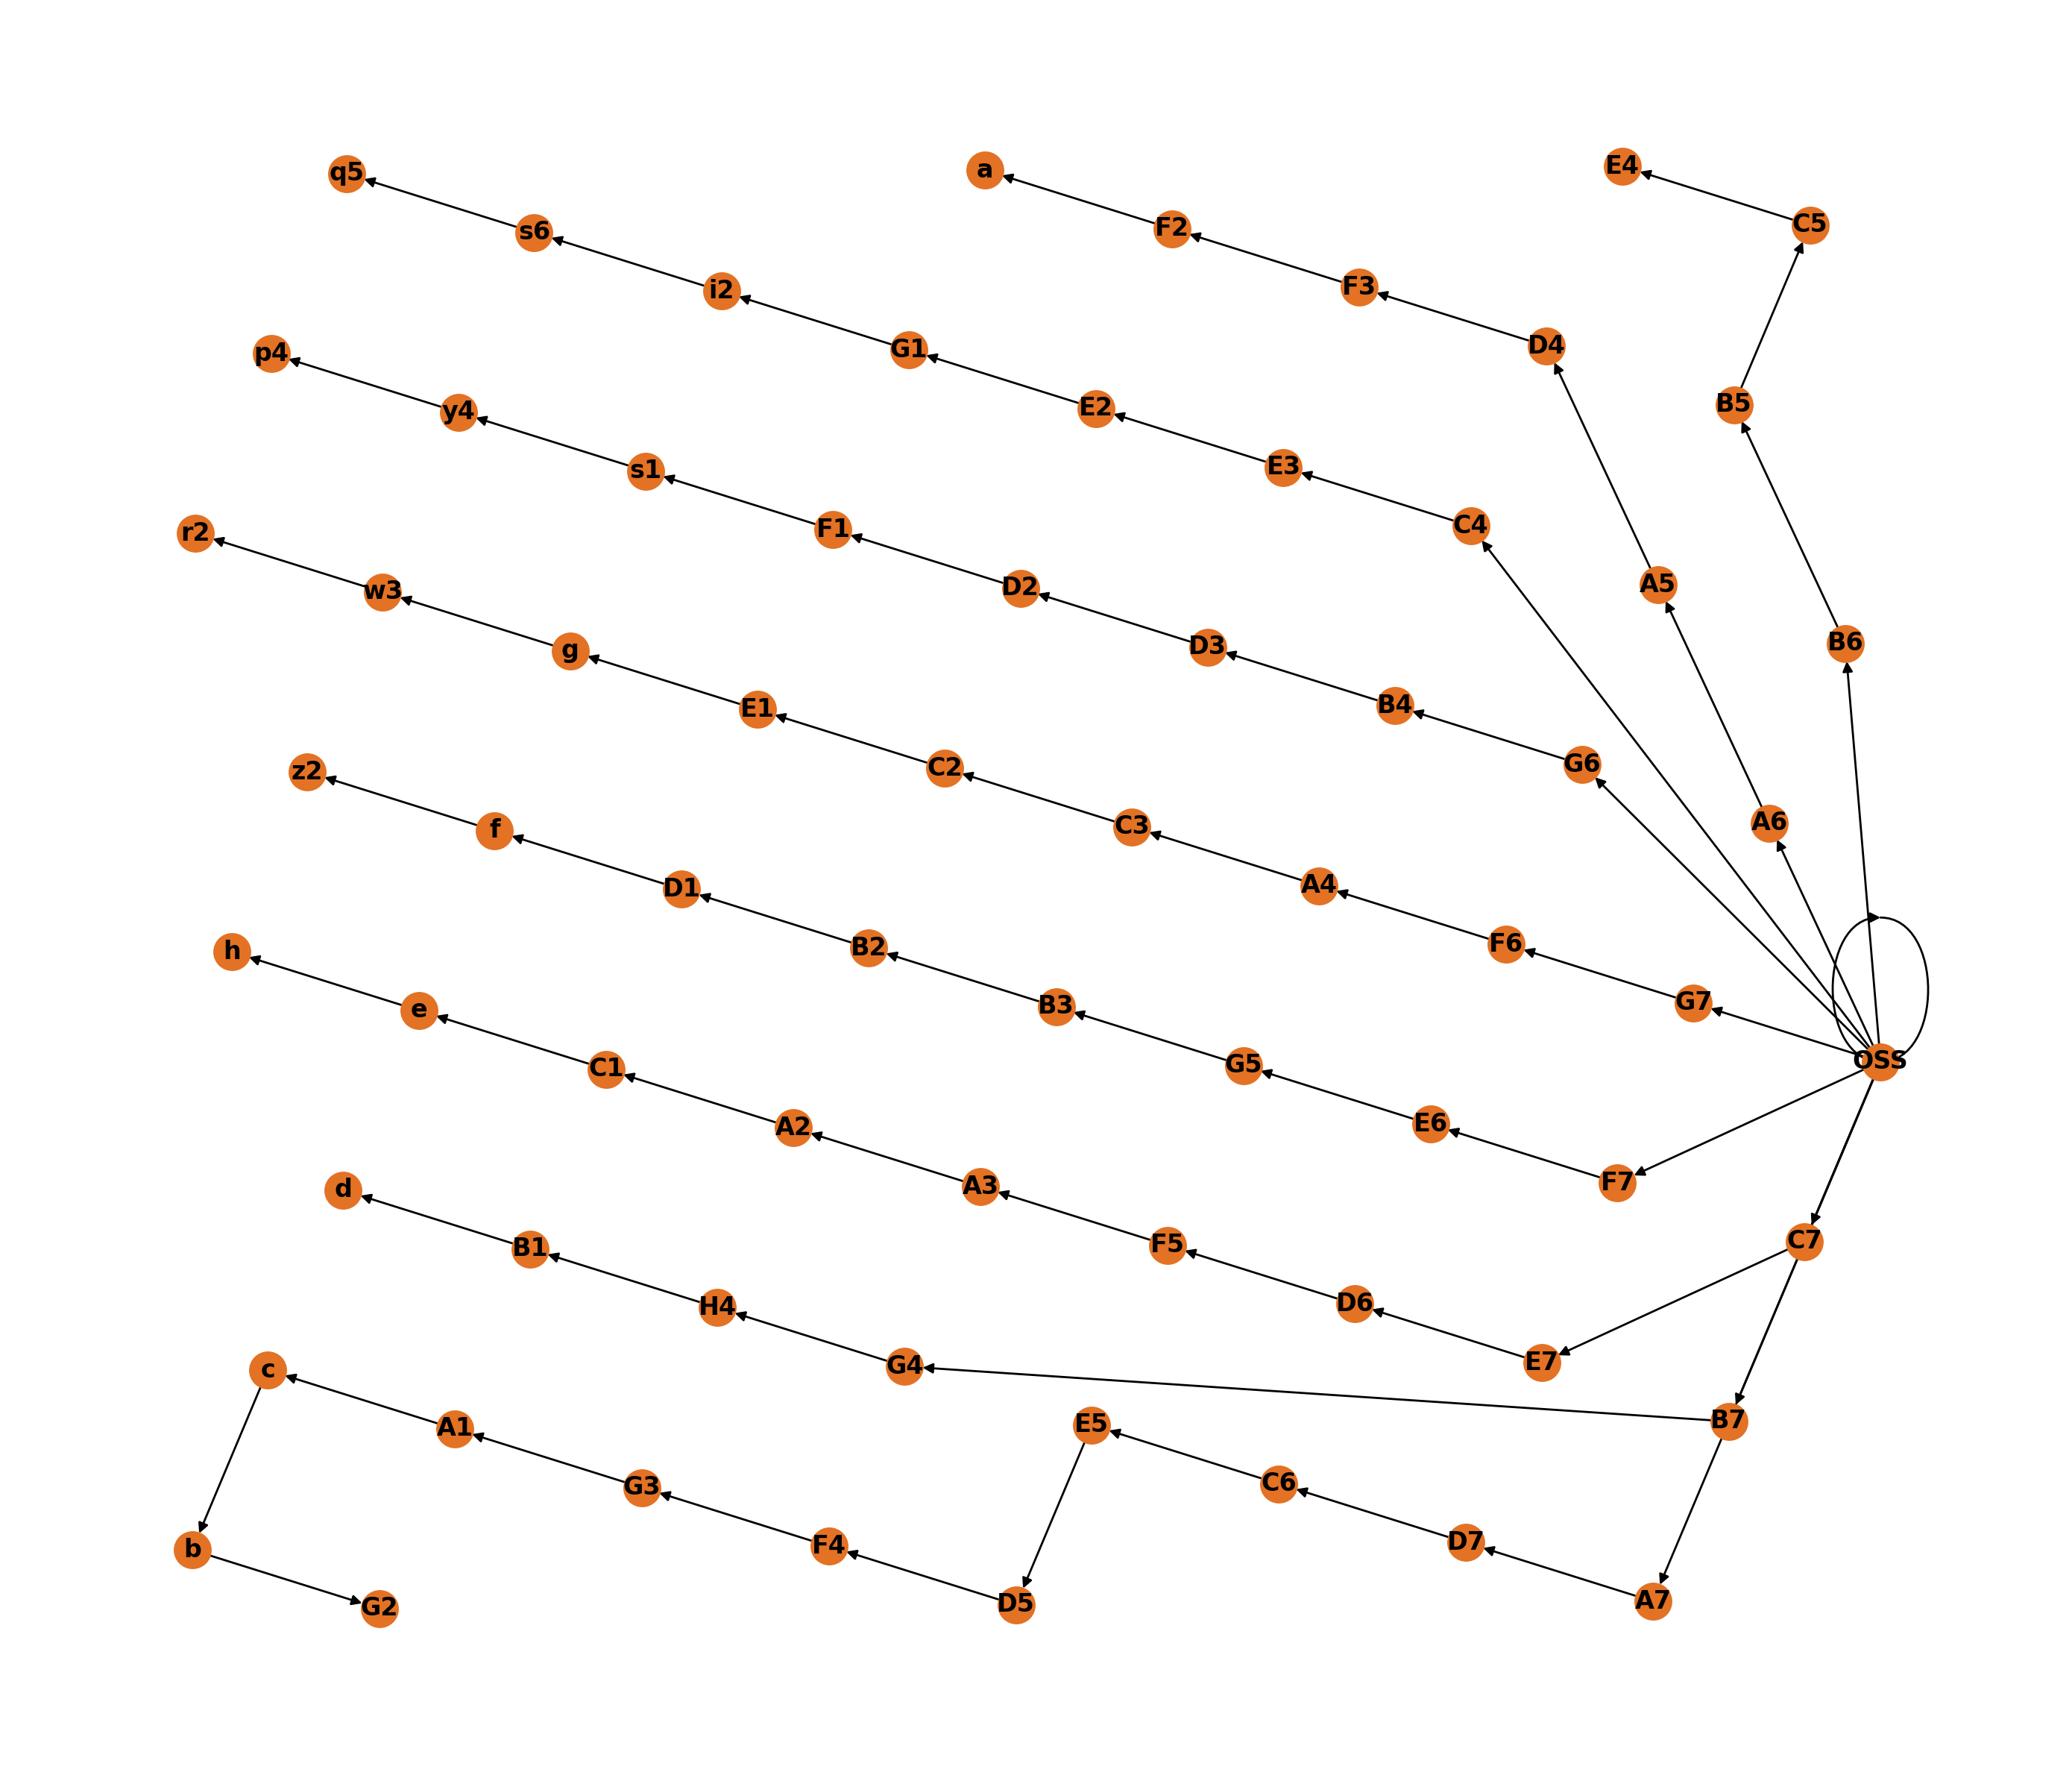

In [6]:
project_floating.plot_farm()